## this will be another attempt to create a budgeted M term

I think we should start with the heat budget and try to do the M term from the advective term

This should ideally be budgeted already because the internal advective terms will cancel.

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

## I think we should start with a very small (2x2 box and see if we can do this)

Any vertical advection should be included in the internal mixing

In [3]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2016"] = np.arange(1,3,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

In [5]:
# we will hard code some example box with gates for now
xs = np.array([[25,26,27,28],[25,26,27,28]])
ys = np.array([[525,525,525,525],[526,526,526,526]])

gatei = np.nanmin(xs)
gateip1 = np.nanmax(xs)
gateip3 = np.nanmax(xs) + 1   # the eastern "gate" index for this range,  we take -advx
gatej = np.nanmin(ys)
gatejp1 = np.nanmin(ys) + 1   # the northern "gate" index we take at j+1 for -advy
gatejp2 = np.nanmax(ys) +1
gatejp2

print(gatei,gateip3)
print(gatej,gatejp2)

25 29
525 527


(520.0, 530.0)

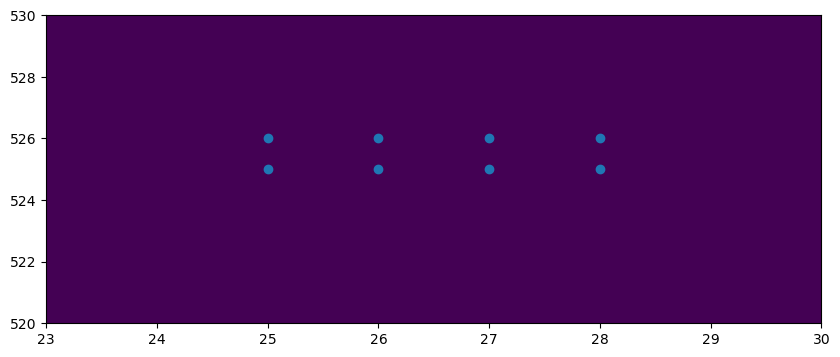

In [6]:
plt.pcolormesh(mymsk)
plt.scatter(xs,ys)
plt.xlim(23,30)
plt.ylim(520,530)

## start with the original salt budget

In [7]:
# total tendency will just be for those two squares
print("doing salt budget")
# create the salt budget
AB_gT=0
AB_gS=0
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s

tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean
budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)

doing salt budget


In [8]:
# print the tendency for those two squares
# take the sum in the second axis to get the total tendency for this array
# we're integrating across the x axis (which is x)
stend = budgO['saltfluxes']['tend'][:,ys,xs]
stend.shape

(50, 2, 4)

In [9]:
# load the original horizontal fluxes and the hconv
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

# calculate the overall horizontal convergence (we don't need here)
tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)
budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))

# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

normaladvconv = (budgO['saltfluxes']['ADV_hconv'][:,ys,xs])
normaladvconv.shape

(50, 2, 4)

In [10]:
tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])


# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux


nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a 

In [11]:
# DF and KPP should be the same

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell
dfconv = budgO['saltfluxes']['DF_Sconv'][:,ys,xs]  # I don't think we want to integrate these for the whole column


tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this
kppconv = budgO['saltfluxes']['KPP_Sconv'][:,ys,xs]

In [12]:
# let's load the Tbins and the Sbins for these columns
# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
#print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    tmpvol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))
#######
print("doing TS binning")
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
SALT = SALT.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

# create the bins of TS data
n_bins = 112

T_min, T_max = -2.0, 15.0
S_min, S_max = 28.0, 37.0

# edges and centers
binsTH_edges   = np.linspace(T_min, T_max, n_bins + 1)
binsSLT_edges  = np.linspace(S_min, S_max, n_bins + 1)
binsTH_centers = 0.5 * (binsTH_edges[:-1]  + binsTH_edges[1:])
binsSLT_centers= 0.5 * (binsSLT_edges[:-1] + binsSLT_edges[1:])

nT = nS = n_bins

# 2D bin grids
Tbin,     Sbin     = np.meshgrid(binsTH_edges,  binsSLT_edges)
Tbincent, Sbincent = np.meshgrid(binsTH_centers, binsSLT_centers)

# bin widths and reshaped versions (match downstream shape)
binwidthT = np.diff(binsTH_edges)
binwidthS = np.diff(binsSLT_edges)
dT, dS = np.meshgrid(binwidthT, binwidthS)
dT = dT.reshape(n_bins, n_bins, 1)
dS = dS.reshape(n_bins, n_bins, 1)

# bin theta and salt
binned_theta = bin_array(THETA, binsTH_edges).astype(float)
binned_theta[binned_theta == nT] = np.nan  # handle right-edge assignment

binned_salinity = bin_array(SALT, binsSLT_edges).astype(float)
binned_salinity[binned_salinity == nS] = np.nan

doing TS binning


In [13]:
# we only really care about the binned_salinity for this region
binned_salinity_col = binned_salinity[:,ys,xs]    # nz,1,2
binned_theta_col = binned_theta[:,ys,xs]

In [14]:
# get the non nan terms in these two columns
hfcsel = mygrid['hFacC'][:,ys,xs]
# nzna = hfcsel[~np.isnan(hfcsel[:,ys,xs])]
# nzna
# hfcsel[18]

In [15]:
nzna = 19

In [17]:
gatei = 25
gateip1 = 26
gateip2 = 27
gateip3 = 28
gateip4 = 29
gatej = 525
gatejp1 = 526
gatejp2 = 527

In [18]:
# the above is not correct, I think we're messing something up with the divide by iTpt and iSpt

## Try the exact same thing with the heat budget to see if we can do

In [19]:
#############################################################################
print("doing heat budget")
# create the heat budget
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/

tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO['heatfluxes'] = {}
budgI['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
# UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[4])
# VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[5])  # m/s

# reshape the UVELMASS and VVELMASS to look at these
# UVELMASS = UVELMASS.reshape(nz,ny,nx)
# VVELMASS = VVELMASS.reshape(nz,ny,nx)

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['heatfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['heathconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

normaladvconv = np.nansum(budgO['heatfluxes']['ADV_hconv'][:,ys,xs],axis = 2)
normaladvconv.shape

doing heat budget


(50, 2)

In [20]:
# get the gateway transports for the ADV term

In [21]:
tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

budgO['heatzconv']=TFLUX+geothFlux+SPforcT1                           # W/m^2 = J/m^2/s
zconv_top_heat = TFLUX  * RAC     # W/m^2 * m^2 = J/s
budgI['heatzconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)

if myparms['useNLFS']==0:
    print(1)
    budgO['heatzconv']=budgO['heatzconv']-myparms['rcp']*WTHMASS[:,:]     # degC.m/s * J/m^3degC = J/m^2.s

budgI['heatzconv']=budgI['heatzconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['heatzconv']=budgI['heatzconv']+SIaaflux

nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_TH) * myparms['rcp']         # J/s
trWtopDF = -(DFrE_TH+DFrI_TH) * myparms['rcp']  # J/s
trWtopKPP = -(KPPg_TH) * myparms['rcp']         # J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP       # J/s
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323
    
trWtop[0,:,:]=budgO['heatzconv']*RAC
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["heatfluxes"]["trWtop"] = trWtop
budgO["heatfluxes"]["trWbot"] = trWbot

budgI["heatfluxes"]["trWtop"] = -RAC * (budgI["heatzconv"] + budgO["heatzconv"])
budgI["heatfluxes"]["trWbot"] = -RAC * budgO["heatzconv"]
budgO['heatfluxes']['zconv']=budgO['heatfluxes']['trWtop']-budgO['heatfluxes']['trWbot']

budgO['heatzconv'] = RAC*budgO['heatzconv']  # J/s
budgI['heatzconv']=RAC*budgI['heatzconv']    # J/s
budgOI['heatzconv']=budgO['heatzconv']+budgI['heatzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['heatfluxes']['ADV_hconv'] + tmpadv   # hconv + zconv
budgO['heatfluxes']['ADV_Tconv'] = Tconv      # J/s, this is the advective arrow of T for a cell

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['heatfluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this

# save these as temporary arrays so we can do the budgeting
dfconv = budgO['heatfluxes']['DF_Tconv'][:,ys,xs]  # I don't think we want to integrate these for the whole column
kppconv = budgO['heatfluxes']['KPP_Tconv'][:,ys,xs]

2


In [22]:
ttend = budgO['heatfluxes']['tend'][:,ys,xs]


# Let's use this and redefine gatesS and gatesT for the same range

In [23]:
# # redefine gatesS and gatesT
# gatesS_N = np.zeros((nz, 1))
# gatesS_S = np.zeros((nz, 1))
# gatesS_E = np.zeros((nz, 1))
# gatesS_W = np.zeros((nz, 1))

# # --- WEST gate (left side) ---
# gatesS_W[:, 0] = tmpADVx_SLT[:, gatej, gatei]

# # --- EAST gate (right side) ---
# gatesS_E[:, 0] = -tmpADVx_SLT[:, gatej, gateip3]

# # --- SOUTH gate (bottom) ---
# gatesS_S[:, 0] = (
#     tmpADVy_SLT[:, gatej, gatei] +
#     tmpADVy_SLT[:, gatej, gateip1]
# )

# # --- NORTH gate (top) ---
# gatesS_N[:, 0] = -(
#     tmpADVy_SLT[:, gatejp1, gatei] +
#     tmpADVy_SLT[:, gatejp1, gateip1]
# )

# # multiply all by density constant
# for g in [gatesS_N, gatesS_S, gatesS_E, gatesS_W]:
#     g *= myparms['rhoconst']


In [24]:
# just hard code the bin widths T and S for now because this doesn't make sense
binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)

## Let's replicate the above with a full T-S budget attempt

In [25]:
def idx_to_bins_formatter(edges):
    def _fmt(x, pos):
        i = int(round(x))
        if 0 <= i < len(edges):
            return f"{edges[i]:g}"
        return ""
    return FuncFormatter(_fmt)

In [26]:
stend = budgO['saltfluxes']['tend'][:,ys,xs]
dfconv = budgO['saltfluxes']['DF_Sconv'][:,ys,xs]  # I don't think we want to integrate these for the whole column
kppconv = budgO['saltfluxes']['KPP_Sconv'][:,ys,xs]
Sconvsel = Sconv[:,ys,xs]

zconv_top_salttmp = zconv_top_salt[ys,xs]  # 2,2
sptoptmp = sptop[:,ys,xs]    # nz,2,2

In [27]:
zconv_top_salttmp.shape

(2, 4)

In [28]:
# JtermsS indices:
# 0: stend
# 1: gate_N
# 2: gate_S
# 3: gate_E
# 4: gate_W
# 5: df
# 6: kpp
# 7: surface
# 8: original sconv
# 9: gate_total (sum of N/S/E/W)

# Faces reshaped to C-grid (u: +east, v: +north)
tmpADVx_SLT = ADVx_SLT.reshape(nz, ny, nx)
tmpADVy_SLT = ADVy_SLT.reshape(nz, ny, nx)

binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)

# ---------- Build boundary flux arrays for a 2x3 tile ----------
# West/East have 2 segments (j=0..1); South/North have 3 segments (i=0..2)
gatesS_N = np.zeros((nz, 4))
gatesS_S = np.zeros((nz, 4))
gatesS_E = np.zeros((nz, 2))
gatesS_W = np.zeros((nz, 2))

# WEST gate (left edge): inward is +east → keep sign
gatesS_W[:, 0] =  tmpADVx_SLT[:, gatej,  gatei]   # bottom segment
gatesS_W[:, 1] =  tmpADVx_SLT[:, gatejp1, gatei]   # top segment

# EAST gate (right edge of a 2x3): inward is +west → negate +east
# NOTE: right boundary u-face is at gateip3 (not gateip2)
gatesS_E[:, 0] = -tmpADVx_SLT[:, gatej,  gateip4]  # bottom segment
gatesS_E[:, 1] = -tmpADVx_SLT[:, gatejp1, gateip4]  # top segment

# SOUTH gate (bottom): inward is +north → keep sign
gatesS_S[:, 0] =  tmpADVy_SLT[:, gatej,  gatei]
gatesS_S[:, 1] =  tmpADVy_SLT[:, gatej,  gateip1]
gatesS_S[:, 2] =  tmpADVy_SLT[:, gatej,  gateip2]
gatesS_S[:, 3] =  tmpADVy_SLT[:, gatej,  gateip3]

# NORTH gate (top of a 2x3): inward is +south → negate +north
# NOTE: top boundary v-face is at gatejp2
gatesS_N[:, 0] = -tmpADVy_SLT[:, gatejp2, gatei]
gatesS_N[:, 1] = -tmpADVy_SLT[:, gatejp2, gateip1]  # m^3·PSU/s
gatesS_N[:, 2] = -tmpADVy_SLT[:, gatejp2, gateip2]
gatesS_N[:, 3] = -tmpADVy_SLT[:, gatejp2, gateip3]


# multiply all by density constant (kept to match your pattern; cancels later)
for g in (gatesS_N, gatesS_S, gatesS_E, gatesS_W):
    g *= myparms['rhoconst']

# ---------- Accumulators ----------
nzna = 19  # max where drf is non-NA
JtermsS = np.zeros((10, nS, nT))  # include slot 9 for gate_total

# --- bulk column terms ---
for j in range(2):      # rows: 0,1
    for i in range(4):  # cols: 0,1,2
        for k in range(nzna):
            iTpt = int(binned_theta_col   [k, j, i])
            iSpt = int(binned_salinity_col[k, j, i])

            JtermsS[0, iSpt, iTpt] += stend   [k, j, i] / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6
            JtermsS[5, iSpt, iTpt] += dfconv  [k, j, i] / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6
            JtermsS[6, iSpt, iTpt] += kppconv [k, j, i] / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6
            JtermsS[8, iSpt, iTpt] += Sconvsel[k, j, i] / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6

# --- surface tendency (fixes pt->j,i) ---
for j in range(2):
    for i in range(4):
        for k in range(nzna):
            iTpt = int(binned_theta_col   [k, j, i])
            iSpt = int(binned_salinity_col[k, j, i])

            if k == 0:
                JtermsS[7, iSpt, iTpt] += (zconv_top_salttmp[j, i] - sptoptmp[k, j, i]) / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6
            else:
                JtermsS[7, iSpt, iTpt] += -(sptoptmp[k, j, i] - sptoptmp[k-1, j, i])    / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6

# --- gate contributions (each cell gets the edges that touch it) ---
for j in range(2):
    for i in range(4):
        for k in range(nzna):
            iTpt = int(binned_theta_col   [k, j, i])
            iSpt = int(binned_salinity_col[k, j, i])

            # SOUTH edge for bottom row cells
            if j == 0:
                JtermsS[2, iSpt, iTpt] += gatesS_S[k, i] / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6  # i=0..2

            # NORTH edge for top row cells
            if j == 1:
                JtermsS[1, iSpt, iTpt] += gatesS_N[k, i] / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6  # i=0..2

            # WEST edge for left column cells
            if i == 0:
                JtermsS[4, iSpt, iTpt] += gatesS_W[k, j] / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6  # j=0..1

            # EAST edge for right column cells
            if i == 2:
                JtermsS[3, iSpt, iTpt] += gatesS_E[k, j] / binwidthTconst / binwidthSconst / myparms['rhoconst'] * 1e-6  # j=0..1

# Optional: total gates = N + S + E + W (slot 9)
JtermsS[9] = JtermsS[1] + JtermsS[2] + JtermsS[3] + JtermsS[4]


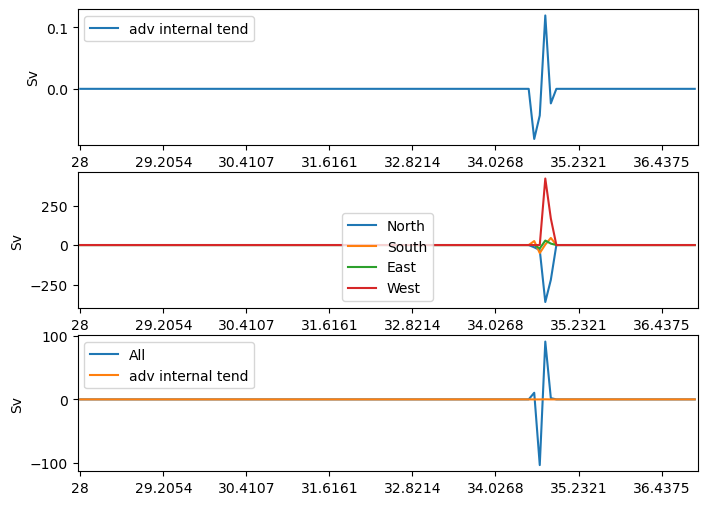

In [29]:
fig = plt.figure(figsize = (8,6))

# plot the overall sum of the gates
ax = plt.subplot(311)
plotthis = np.nansum(JtermsS[8],axis=1)
ax.plot(plotthis,label="adv internal tend")
# ax.plot(np.nansum(J_gates,axis=(0,1))*1e-3)
ax.set_ylabel("Sv")
ax.set_xlim(-0.5, nS - 0.5)                     # keep ticks aligned to integer indices
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(idx_to_bins_formatter(binsSLT_edges))
ax.legend(loc="best")

ax = plt.subplot(312)
plotthis = np.nansum(JtermsS[1],axis=1)
ax.plot(plotthis,label="North")
plotthis = np.nansum(JtermsS[2],axis=1)
ax.plot(plotthis,label="South")
plotthis = np.nansum(JtermsS[3],axis=1)
ax.plot(plotthis,label="East")
plotthis = np.nansum(JtermsS[4],axis=1)
ax.plot(plotthis,label="West")
ax.set_ylabel("Sv")
ax.set_xlim(-0.5, nS - 0.5)                     # keep ticks aligned to integer indices
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(idx_to_bins_formatter(binsSLT_edges))
ax.legend(loc="best")


ax = plt.subplot(313)
plotthis = np.nansum(JtermsS[1:5],axis=(0,2))
ax.plot(plotthis,label="All")
plotthis = np.nansum(JtermsS[8],axis=1)
ax.plot(plotthis,label="adv internal tend")
# ax.plot(np.nansum(J_gates,axis=(0,1))*1e-3)
ax.set_ylabel("Sv")
ax.set_xlim(-0.5, nS - 0.5)                     # keep ticks aligned to integer indices
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(idx_to_bins_formatter(binsSLT_edges))
ax.legend(loc="best")

In [30]:
print(np.nansum(JtermsS[8],axis=(0,1)))         # summing in T and S
print(np.nansum(JtermsS[1:5],axis=(0,1,2)))     # summing in S
print((np.nansum(JtermsS[8],axis=(0,1))) - (np.nansum(JtermsS[1:5],axis=(0,1,2))))  # this would show that internal adv is same as gates

-0.02928287617106695
-0.029282876171123462
5.651035195342047e-14


In [31]:
# print the overall sum of these to make sure we

In [32]:
a =  np.nansum(JtermsS[1:5],axis=(0,2))
b = np.nansum(JtermsS[8],axis=1)
print(np.nansum(a),np.nansum(b))

-0.02928287617108083 -0.029282876171066965


## Try a version of this where we divide by volume to see if this makes sense

In [33]:
gate_conv_TS = np.zeros((nS, nT))
denom = binwidthTconst * binwidthSconst * myparms['rhoconst']

for k in range(nzna):
    for j in range(2):      # rows: 0 (south), 1 (north)
        for i in range(3):  # cols: 0 (west), 1 (mid), 2 (east)
            iT = int(binned_theta_col   [k, j, i])
            iS = int(binned_salinity_col[k, j, i])

            net = 0.0
            # external south edge for bottom row
            if j == 0:
                net += gatesS_S[k, i]        # i = 0..2
            # external north edge for top row
            if j == 1:
                net += gatesS_N[k, i]        # i = 0..2
            # external west edge for left column
            if i == 0:
                net += gatesS_W[k, j]        # j = 0..1
            # external east edge for right column
            if i == 2:
                net += gatesS_E[k, j]        # j = 0..1

            gate_conv_TS[iS, iT] += net / denom

gate_conv_TS *= 1e-6  # Sv


(2.0, 5.0)

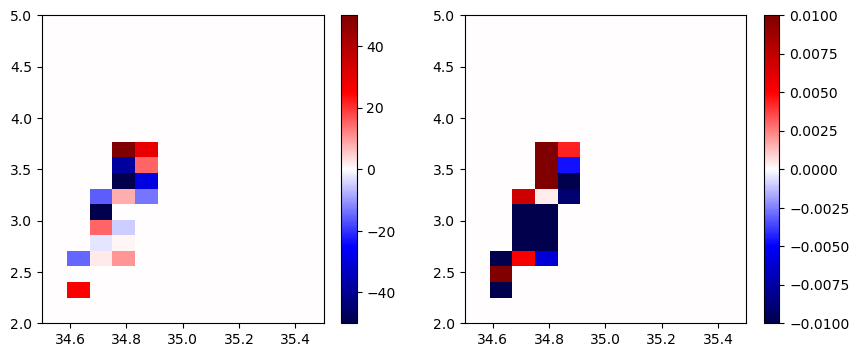

In [38]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(JtermsS[1:5],axis=(0)),vmin=-50,vmax=50,cmap='seismic')
plt.colorbar(cb)
ax.set_xlim(34.5,35.5)
ax.set_ylim(2,5)

ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin,Tbin,JtermsS[8],vmin=-.01,vmax=0.01,cmap='seismic')
plt.colorbar(cb)
ax.set_xlim(34.5,35.5)
ax.set_ylim(2,5)

In [39]:
np.nansum(np.nansum(JtermsS[1:5],axis=(0)))

-0.02928287617101688

In [40]:
np.nansum(JtermsS[8])

-0.02928287617106695

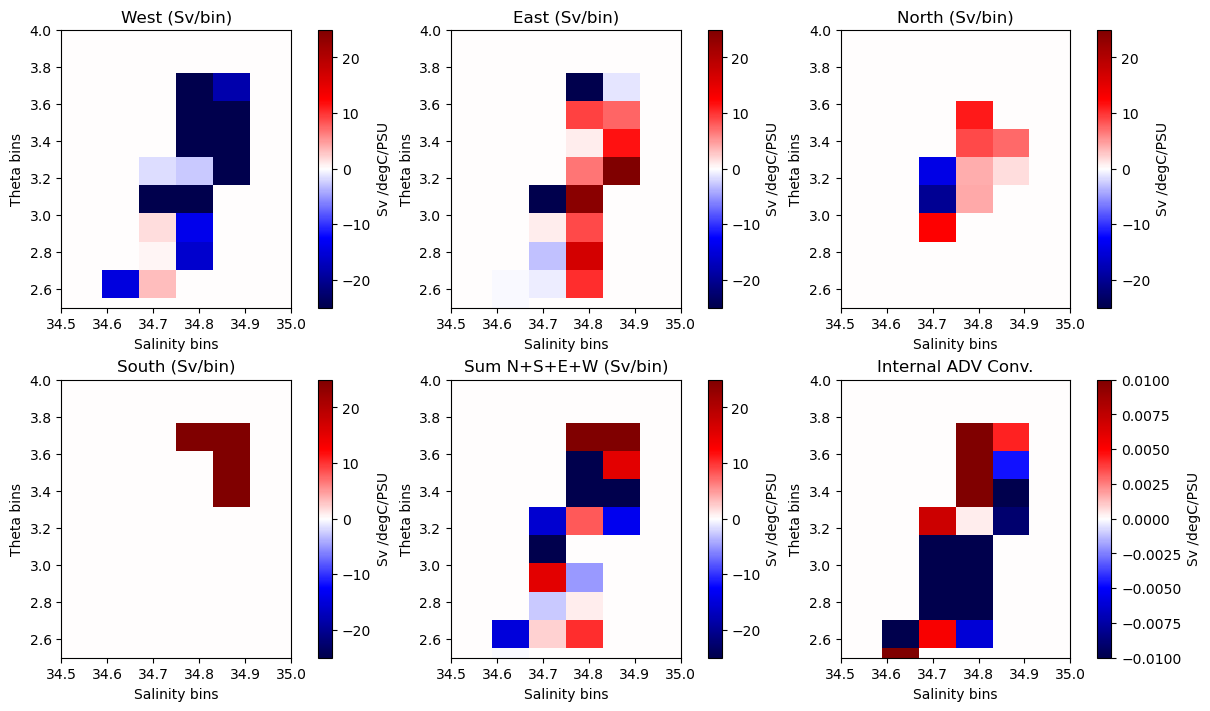

In [42]:
# Per-direction TS arrays (Sv per T–S bin) for a 2×3 tile:
# (j,i): j=0 bottom row, j=1 top row; i=0 left, 1 middle, 2 right
gate_W_TS = np.zeros((nS, nT))
gate_E_TS = np.zeros((nS, nT))
gate_N_TS = np.zeros((nS, nT))
gate_S_TS = np.zeros((nS, nT))

norm = binwidthTconst * binwidthSconst * myparms['rhoconst']

for k in range(nzna):
    for j in range(2):      # rows: 0 (south), 1 (north)
        for i in range(3):  # cols: 0 (west), 1 (mid), 2 (east)
            iT = int(binned_theta_col   [k, j, i])
            iS = int(binned_salinity_col[k, j, i])

            # WEST edge contributes only to left column cells
            if i == 0:
                gate_W_TS[iS, iT] += gatesS_W[k, j] / norm   # j=0..1

            # EAST edge contributes only to right column cells
            if i == 2:
                gate_E_TS[iS, iT] += gatesS_E[k, j] / norm   # j=0..1

            # SOUTH edge contributes only to bottom row cells
            if j == 0:
                gate_S_TS[iS, iT] += gatesS_S[k, i] / norm   # i=0..2

            # NORTH edge contributes only to top row cells
            if j == 1:
                gate_N_TS[iS, iT] += gatesS_N[k, i] / norm   # i=0..2

# Convert to Sv
scale = 1e-6
gate_W_TS *= scale
gate_E_TS *= scale
gate_N_TS *= scale
gate_S_TS *= scale

# Net gate contribution per bin (sum of directions)
gate_SUM_TS = gate_W_TS + gate_E_TS + gate_N_TS + gate_S_TS

# (Optional) consistency check vs your aggregate gate_conv_TS (also in Sv)
# print("max|diff| =", np.nanmax(np.abs(gate_SUM_TS - gate_conv_TS)))

# ---- Plot 5 separate T–S diagrams ----
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

def plot_ts(ax, Z, title):
    # Sbin: salinity bin edges (y), Tbin: theta bin edges (x)
    pcm = ax.pcolormesh(Sbin, Tbin, Z, cmap='seismic', vmin=-25, vmax=25)
    ax.set_title(title)
    ax.set_ylabel('Theta bins')
    ax.set_xlabel('Salinity bins')
    fig.colorbar(pcm, ax=ax, label='Sv /degC/PSU')
    ax.set_xlim(34.5, 35)
    ax.set_ylim(2.5, 4)

# If you prefer a unified symmetric color scale across all:
# v = np.nanmax(np.abs(np.stack([gate_W_TS, gate_E_TS, gate_N_TS, gate_S_TS, gate_SUM_TS])))
# v = max(v, 1e-12)
# clim = dict(vmin=-v, vmax=v)
# Then pass **clim to plot_ts instead of fixed vmin/vmax.

plot_ts(axs[0,0], JtermsS[1],   'West (Sv/bin)')
plot_ts(axs[0,1], JtermsS[2],   'East (Sv/bin)')
plot_ts(axs[0,2], JtermsS[3],   'North (Sv/bin)')
plot_ts(axs[1,0], JtermsS[4],   'South (Sv/bin)')
plot_ts(axs[1,1], np.nansum(JtermsS[1:5],axis=0), 'Sum N+S+E+W (Sv/bin)')

# 6th panel: internal advective convergence (your JtermsS[8])
pcm = axs[1,2].pcolormesh(Sbin, Tbin, JtermsS[8], vmin=-0.01, vmax=0.01, cmap='seismic')
axs[1,2].set_ylabel('Theta bins')
axs[1,2].set_xlabel('Salinity bins')
fig.colorbar(pcm, ax=axs[1,2], label='Sv /degC/PSU')
axs[1,2].set_xlim(34.5, 35)
axs[1,2].set_ylim(2.5, 4)
axs[1,2].set_title("Internal ADV Conv.")

plt.show()


## continue for T budget for the two squares

In [43]:
ttend = budgO['heatfluxes']['tend'][:,ys,xs]
dfconv = budgO['heatfluxes']['DF_Tconv'][:,ys,xs]  # I don't think we want to integrate these for the whole column
kppconv = budgO['heatfluxes']['KPP_Tconv'][:,ys,xs]
Tconvsel = Sconv[:,ys,xs]

zconv_top_heattmp = zconv_top_heat[ys,xs]  # 2,2
swtoptmp = swtop[:,ys,xs]    # nz,2,2

In [99]:
# JtermsS indices:
# 0: stend
# 1: gate_N
# 2: gate_S
# 3: gate_E
# 4: gate_W
# 5: df
# 6: kpp
# 7: surface
# 8: original sconv
# 9: gate_total (sum of N/S/E/W)

# Faces reshaped to C-grid (u: +east, v: +north)
tmpADVx_TH = ADVx_TH.reshape(nz, ny, nx)
tmpADVy_TH = ADVy_TH.reshape(nz, ny, nx)

binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)

# ---------- Build boundary flux arrays for a 2x3 tile ----------
# West/East have 2 segments (j=0..1); South/North have 3 segments (i=0..2)
gatesT_N = np.zeros((nz, 3))
gatesT_S = np.zeros((nz, 3))
gatesT_E = np.zeros((nz, 2))
gatesT_W = np.zeros((nz, 2))

# WEST gate (left edge): inward is +east → keep sign
gatesT_W[:, 0] =  tmpADVx_TH[:, gatej,  gatei]   # bottom segment
gatesT_W[:, 1] =  tmpADVx_TH[:, gatejp1, gatei]   # top segment

# EAST gate (right edge of a 2x3): inward is +west → negate +east
# NOTE: right boundary u-face is at gateip3 (not gateip2)
gatesT_E[:, 0] = -tmpADVx_TH[:, gatej,  gateip3]  # bottom segment
gatesT_E[:, 1] = -tmpADVx_TH[:, gatejp1, gateip3]  # top segment

# SOUTH gate (bottom): inward is +north → keep sign
gatesT_S[:, 0] =  tmpADVy_TH[:, gatej,  gatei]
gatesT_S[:, 1] =  tmpADVy_TH[:, gatej,  gateip1]
gatesT_S[:, 2] =  tmpADVy_TH[:, gatej,  gateip2]

# NORTH gate (top of a 2x3): inward is +south → negate +north
# NOTE: top boundary v-face is at gatejp2
gatesT_N[:, 0] = -tmpADVy_TH[:, gatejp2, gatei]
gatesT_N[:, 1] = -tmpADVy_TH[:, gatejp2, gateip1]  # m^3·PSU/s
gatesT_N[:, 2] = -tmpADVy_TH[:, gatejp2, gateip2]

# multiply all by density constant (kept to match your pattern; cancels later)
for g in (gatesT_N, gatesT_S, gatesT_E, gatesT_W):
    g *= myparms['rcp']

# ---------- Accumulators ----------
nzna = 19  # max where drf is non-NA
JtermsT = np.zeros((10, nS, nT))  # include slot 9 for gate_total

# --- bulk column terms ---
for j in range(2):      # rows: 0,1
    for i in range(3):  # cols: 0,1,2
        for k in range(nzna):
            iTpt = int(binned_theta_col   [k, j, i])
            iSpt = int(binned_salinity_col[k, j, i])

            JtermsT[0, iSpt, iTpt] += ttend   [k, j, i] / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6
            JtermsT[5, iSpt, iTpt] += dfconv  [k, j, i] / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6
            JtermsT[6, iSpt, iTpt] += kppconv [k, j, i] / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6
            JtermsT[8, iSpt, iTpt] += Tconvsel[k, j, i] / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6

# --- surface tendency (fixes pt->j,i) ---
for j in range(2):
    for i in range(3):
        for k in range(nzna):
            iTpt = int(binned_theta_col   [k, j, i])
            iSpt = int(binned_salinity_col[k, j, i])

            if k == 0:
                JtermsT[7, iSpt, iTpt] += (zconv_top_heattmp[j,i] - swtoptmp[k,j,i]) / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6
            else:
                JtermsT[7, iSpt, iTpt] += -(swtoptmp[k+1,j,i] - swtoptmp[k,j,i]) / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6

# --- gate contributions (each cell gets the edges that touch it) ---
for j in range(2):
    for i in range(3):
        for k in range(nzna):
            iTpt = int(binned_theta_col   [k, j, i])
            iSpt = int(binned_salinity_col[k, j, i])

            # SOUTH edge for bottom row cells
            if j == 0:
                JtermsT[2, iSpt, iTpt] += gatesT_S[k, i] / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6  # i=0..2

            # NORTH edge for top row cells
            if j == 1:
                JtermsT[1, iSpt, iTpt] += gatesT_N[k, i] / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6  # i=0..2

            # WEST edge for left column cells
            if i == 0:
                JtermsT[4, iSpt, iTpt] += gatesT_W[k, j] / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6  # j=0..1

            # EAST edge for right column cells
            if i == 2:
                JtermsT[3, iSpt, iTpt] += gatesT_E[k, j] / binwidthTconst / binwidthSconst / myparms['rcp'] * 1e-6  # j=0..1

# Optional: total gates = N + S + E + W (slot 9)
JtermsT[9] = JtermsT[1] + JtermsT[2] + JtermsT[3] + JtermsT[4]


In [100]:
np.nansum(JtermsT[1:5])

2.9937290635129727

In [101]:
##########################################################
print("doing JtermsT")
# make this a for loop for points just to start
JtermsT = np.zeros((5,nS,nT))

# get the data (will be the same for all points)
aT = budgO['heatfluxes']['tend']  # J/s
bT = budgO['heatfluxes']['ADV_Tconv']   # ADVx_TH degC.m^3/s * rcp = J/s 
cT = budgO['heatfluxes']['DF_Tconv']
dT = budgO['heatfluxes']['KPP_Tconv']
eT = zconv_top_heat.reshape(1,ny,nx)
fT = swtop

for i,j in zip(ys[0],xs[0]):

    # loop through the z values and see if we can plot
    for k in range(0,19):                 # stop at second to last level for 
        #print(k,i,j)
        iTpt = int(binned_theta[k,i,j])
        iSpt = int(binned_salinity[k,i,j])

        # save the J terms for here for the single point  
        #           J/s   / (kg/m^3 * J/kg.degC) /    degC       /  PSU
        #           J/s   *  (m^3 . degC / J)   / deC     / PSU  
        JtendT = (aT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6             # Sv/PSU
        JADVT = (bT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/PSU
        JDFT = (cT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6               # Sv/PSU
        JKPPT = (dT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6              # Sv/PSU

        if k == 0:
            JsurfT = (eT[k,i,j] - fT[k+1,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 # Sv/PSU
        else:
            JsurfT = -(fT[k+1,i,j] - fT[k,i,j]) / myparms['rcp'] / binwidthT[iTpt] / binwidthS[iSpt] * 1e-6 # Sv/PSU

        # set these in meshes so we can plot
        c = 0
        for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
            #print(valT)
            JtermsT[c,iSpt,iTpt] += valT
            c += 1

print("total residual",np.nansum(JtermsT[0] - JtermsT[1] - JtermsT[2] - JtermsT[3] - JtermsT[4]),"Sv/PSU")

doing JtermsT
total residual -1.1053137169540772e-13 Sv/PSU


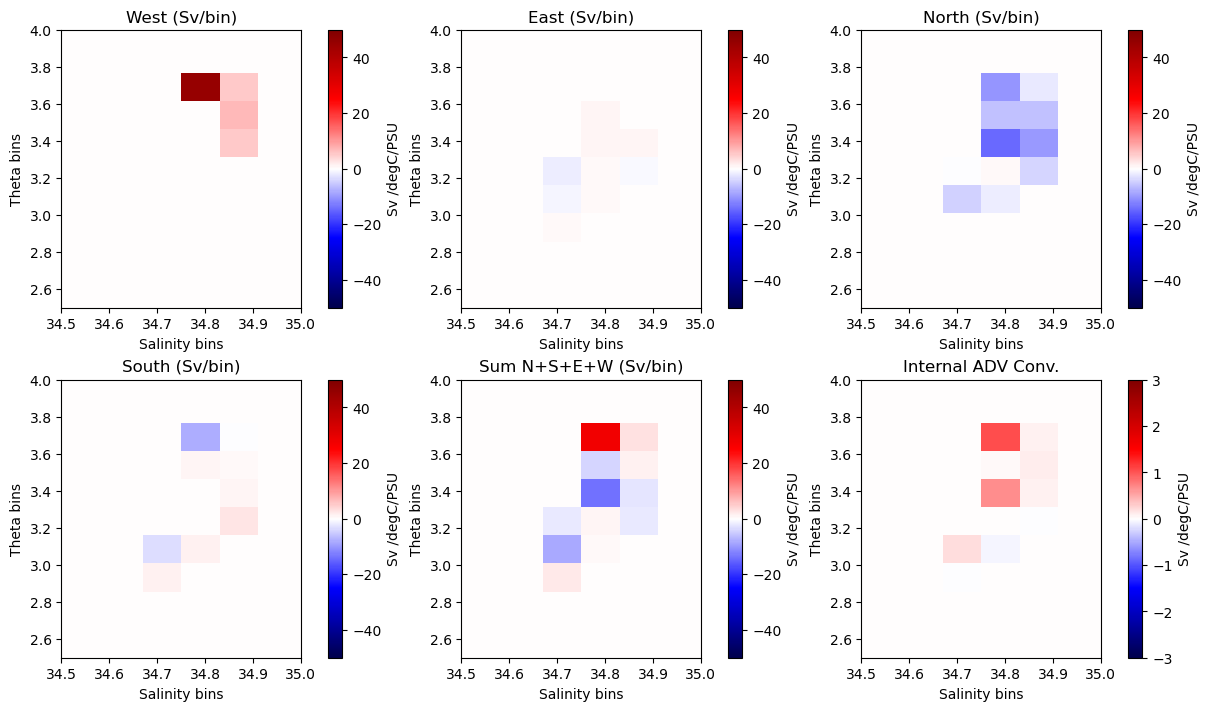

In [102]:
# ---------- Build boundary flux arrays for a 2x3 tile ----------
# West/East have 2 segments (j=0..1); South/North have 3 segments (i=0..2)
gatesT_N = np.zeros((nz, 3))
gatesT_S = np.zeros((nz, 3))
gatesT_E = np.zeros((nz, 2))
gatesT_W = np.zeros((nz, 2))

# WEST gate (left edge): inward is +east → keep sign
gatesT_W[:, 0] =  tmpADVx_TH[:, gatej,  gatei]   # bottom segment
gatesT_W[:, 1] =  tmpADVx_TH[:, gatejp1, gatei]   # top segment

# EAST gate (right edge of a 2x3): inward is +west → negate +east
# NOTE: right boundary u-face is at gateip3 (not gateip2)
gatesT_E[:, 0] = -tmpADVx_TH[:, gatej,  gateip3]  # bottom segment
gatesT_E[:, 1] = -tmpADVx_TH[:, gatejp1, gateip3]  # top segment

# SOUTH gate (bottom): inward is +north → keep sign
gatesT_S[:, 0] =  tmpADVy_TH[:, gatej,  gatei]
gatesT_S[:, 1] =  tmpADVy_TH[:, gatej,  gateip1]
gatesT_S[:, 2] =  tmpADVy_TH[:, gatej,  gateip2]

# NORTH gate (top of a 2x3): inward is +south → negate +north
# NOTE: top boundary v-face is at gatejp2
gatesT_N[:, 0] = -tmpADVy_TH[:, gatejp2, gatei]
gatesT_N[:, 1] = -tmpADVy_TH[:, gatejp2, gateip1]  # m^3·PSU/s
gatesT_N[:, 2] = -tmpADVy_TH[:, gatejp2, gateip2]

# multiply all by density constant (kept to match your pattern; cancels later)
for g in (gatesT_N, gatesT_S, gatesT_E, gatesT_W):
    g *= myparms['rcp']

# Per-direction TS arrays (Sv per T–S bin) for a 2×3 tile:
# (j,i): j=0 bottom row, j=1 top row; i=0 left, 1 middle, 2 right
gate_W_TS = np.zeros((nS, nT))
gate_E_TS = np.zeros((nS, nT))
gate_N_TS = np.zeros((nS, nT))
gate_S_TS = np.zeros((nS, nT))

norm = binwidthTconst * binwidthSconst * myparms['rcp']

for k in range(nzna):
    for j in range(2):      # rows: 0 (south), 1 (north)
        for i in range(3):  # cols: 0 (west), 1 (mid), 2 (east)
            iT = int(binned_theta_col   [k, j, i])
            iS = int(binned_salinity_col[k, j, i])

            # WEST edge contributes only to left column cells
            if i == 0:
                gate_W_TS[iS, iT] += gatesT_W[k, j] / norm   # j=0..1

            # EAST edge contributes only to right column cells
            if i == 2:
                gate_E_TS[iS, iT] += gatesT_E[k, j] / norm   # j=0..1

            # SOUTH edge contributes only to bottom row cells
            if j == 0:
                gate_S_TS[iS, iT] += gatesT_S[k, i] / norm   # i=0..2

            # NORTH edge contributes only to top row cells
            if j == 1:
                gate_N_TS[iS, iT] += gatesT_N[k, i] / norm   # i=0..2

# Convert to Sv
scale = 1e-6
gate_W_TS *= scale
gate_E_TS *= scale
gate_N_TS *= scale
gate_S_TS *= scale

# Net gate contribution per bin (sum of directions)
gate_SUM_TS = gate_W_TS + gate_E_TS + gate_N_TS + gate_S_TS

# (Optional) consistency check vs your aggregate gate_conv_TS (also in Sv)
# print("max|diff| =", np.nanmax(np.abs(gate_SUM_TS - gate_conv_TS)))

# ---- Plot 5 separate T–S diagrams ----
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

def plot_ts(ax, Z, title):
    # Sbin: salinity bin edges (y), Tbin: theta bin edges (x)
    pcm = ax.pcolormesh(Sbin, Tbin, Z, cmap='seismic', vmin=-50, vmax=50)
    ax.set_title(title)
    ax.set_ylabel('Theta bins')
    ax.set_xlabel('Salinity bins')
    fig.colorbar(pcm, ax=ax, label='Sv /degC/PSU')
    ax.set_xlim(34.5, 35)
    ax.set_ylim(2.5, 4)

# If you prefer a unified symmetric color scale across all:
# v = np.nanmax(np.abs(np.stack([gate_W_TS, gate_E_TS, gate_N_TS, gate_S_TS, gate_SUM_TS])))
# v = max(v, 1e-12)
# clim = dict(vmin=-v, vmax=v)
# Then pass **clim to plot_ts instead of fixed vmin/vmax.

plot_ts(axs[0,0], gate_W_TS,   'West (Sv/bin)')
plot_ts(axs[0,1], gate_E_TS,   'East (Sv/bin)')
plot_ts(axs[0,2], gate_N_TS,   'North (Sv/bin)')
plot_ts(axs[1,0], gate_S_TS,   'South (Sv/bin)')
plot_ts(axs[1,1], gate_SUM_TS, 'Sum N+S+E+W (Sv/bin)')

# 6th panel: internal advective convergence (your JtermsS[8])
pcm = axs[1,2].pcolormesh(Sbin, Tbin, JtermsT[1], vmin=-3, vmax=3, cmap='seismic')
axs[1,2].set_ylabel('Theta bins')
axs[1,2].set_xlabel('Salinity bins')
fig.colorbar(pcm, ax=axs[1,2], label='Sv /degC/PSU')
axs[1,2].set_xlim(34.5, 35)
axs[1,2].set_ylim(2.5, 4)
axs[1,2].set_title("Internal ADV Conv.")

plt.show()

In [103]:
np.nansum(JtermsT[1])

2.129910841042523